In [20]:
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import itertools
import socket
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import time
import holidays
import pycountry
import optuna

import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from IPython.display import display
from IPython.display import clear_output

In [21]:
# Declare important variables
train_path = 'train.csv'
test_path = 'test.csv'
submission_path = 'sample_submission.csv'
target_variable = 'base_level'
SEED = 69
skip_hypertuning = True
cat_encoder_type = 'OneHotEncoder' #OneHotEncoder, FrequencyEncoder, None

In [22]:
def load_dataframes(path1: str, path2: str, format1: str = "csv", format2: str = "csv") -> tuple:

    loaders = {
        "csv": pd.read_csv,
        "excel": pd.read_excel,
        "json": pd.read_json,
    }

    if format1 not in loaders or format2 not in loaders:
        raise ValueError("Unsupported format. Supported formats: 'csv', 'excel', 'json'.")

    # Load the dataframes using appropriate loaders
    df1 = loaders[format1](path1)
    df2 = loaders[format2](path2)

    print(f"Loading data from {os.getcwd()}")
    
    return df1, df2

In [23]:
train, test = load_dataframes(train_path,test_path)

Loading data from C:\Users\ZaneC\OneDrive\Documents\Python\Kaggle\Bond


In [24]:
# Add a 'dataset' column to distinguish between train and test data
train['dataset'] = 'train'
test['dataset'] = 'test'

# Concatenate the datasets along rows and reset the index
df = pd.concat([train, test], axis=0).reset_index(drop=True)

# Rename the target variable column to 'y'
df = df.rename(columns={target_variable: 'y'})

In [25]:
def get_num_cols(df: pd.DataFrame):
    num_cols = df.select_dtypes(include=['number']).columns.to_list()
    
    return num_cols

def get_cat_cols(df: pd.DataFrame):
    cat_cols = df.select_dtypes(include=['object', 'string', 'category']).columns.tolist()  

    return cat_cols

In [26]:
def describe_dataframe(df_to_use: pd.DataFrame, name: str = 'DataFrame', nrows: int = 3, plots: bool = False, info: bool = True) -> None:
    '''
    Function to describe the DataFrame with summary statistics, missing value count,
    unique value count, and duplicate count. It also displays plots for missing and unique values.
    
    Parameters:
    - df: The DataFrame to describe.
    - name: The name to display in the summary (default is 'DataFrame').
    - nrows: The number of rows to display from the top and bottom (default is 3).
    - plots: Whether to display bar plots for missing and unique values (default is False).
    - info: Whether to display the styled DataFrame (default is True).
    '''

    df = df_to_use.copy()   
    
    # Create summary DataFrame
    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    
    # Missing values
    df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})
    df_missing['pct_missing'] = (df_missing['missing'] / df.shape[0]) * 100
    
    # Unique values
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    
    # Combine summary information
    inf['missing'] = df_missing['missing']
    inf['pct_missing'] = df_missing['pct_missing']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()
    inf['count'] = df.shape[0]

    # Descriptive statistics
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values 
    
    # Display styled DataFrame
    if info:
        display(inf.style.background_gradient(subset=['missing','pct_missing'], cmap='Reds').background_gradient(subset='unique', cmap='Greens'))

    if nrows != 0 :
        # Display top and bottom nrows of the DataFrame
        print(f"\n---------- {name} Overview ----------:")
        print(f"{name} has {df.shape[0]} rows and {df.shape[1]} columns\n")
        display(df.head(nrows))
        display(df.tail(nrows))
    
    # Plot missing values if any
    if plots and df_missing['missing'].sum() > 0:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_missing[df_missing['missing'] > 0], x='column', y='missing', ax=ax)
        ax.set_title(f'{name} missing Values') 
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()
    
        # Plot unique values
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
        ax.set_title(f'{name} Unique Values')
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()

In [27]:
describe_dataframe(df, name='Bond Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,risk_sec_code,int64,0,0.000000,7049,0,1303366,1122217.000000,5609595.000000,5245173.965526,309653.416765,nan,nan
1,close_date,object,0,0.000000,450,0,1303366,nan,nan,nan,nan,2025-01-13,7049
2,y,float64,1229,0.094294,1295388,0,1303366,0.000000,10.272980,3.972316,1.786870,nan,nan
3,prc,float64,0,0.000000,1220083,0,1303366,68.592808,119.699841,96.942636,5.633760,nan,nan
4,cpn,float64,0,0.000000,1250,0,1303366,0.000000,9.625000,3.377475,1.778457,nan,nan
5,mturty_date,object,0,0.000000,2292,0,1303366,nan,nan,nan,nan,2027-03-15,6142
6,next_inc_date,object,0,0.000000,688,0,1303366,nan,nan,nan,nan,2025-01-15,30989
7,accrd_mthd,object,0,0.000000,11,0,1303366,nan,nan,nan,nan,30/360,587851
8,is_callable,object,0,0.000000,2,0,1303366,nan,nan,nan,nan,Y,908157
9,is_putable,object,0,0.000000,1,0,1303366,nan,nan,nan,nan,N,1303366


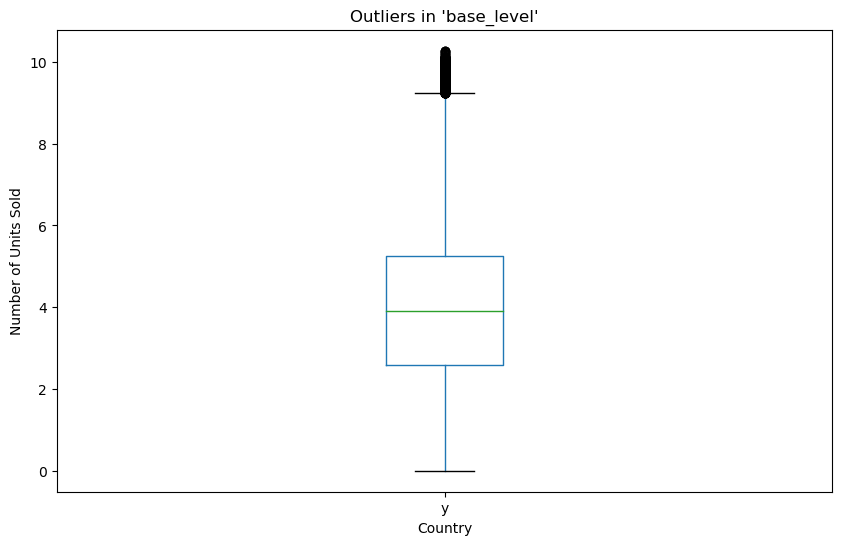

In [28]:
plt.figure(figsize=(10, 6))
df.boxplot(column='y', grid=False)
plt.title("Outliers in 'base_level'")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel('Number of Units Sold')
plt.xlabel('Country')
plt.show()

In [29]:
def parse_dates(date):
    # Attempt to parse in the first format
    parsed_date = pd.to_datetime(date, format="%Y-%m-%d", errors='coerce')
    if pd.isna(parsed_date):
        # If the first format fails, try the second format
        parsed_date = pd.to_datetime(date, format="%m/%d/%Y", errors='coerce')
        
    # If both formats fail, return the original invalid date
    if pd.isna(parsed_date):
        return date
    
    return parsed_date

In [30]:
date_cols = ['close_date','mturty_date','next_inc_date','dated_date','prev_inc_date','last_inc_date']
# Convert date column from object to datetime
for c in date_cols:
    df[c] = df[c].apply(parse_dates)   
    

In [31]:
def clean_dataframe(df_to_use: pd.DataFrame, impute_num_nulls: bool = True, fill_cat_nulls: bool = True) -> None:
    df = df_to_use.copy()

    
    for c in ['is_callable','is_putable']:
        df[c].map({'Y':1,'N':0})

    # Fill nulls in numeric columns with the median
    if impute_num_nulls:
        # Filter columns where the type is either 'float' or 'int' and there are missing values
        numeric_cols = df.select_dtypes(include=['number']).columns
        missing_numeric_columns = [
            col for col in numeric_cols if df[col].isnull().sum() > 0
            ]    
        # Target field 'num_sold' is missing some values, we do not want to impute them
        if 'y' in missing_numeric_columns:
            missing_numeric_columns.remove('y')
        for column in missing_numeric_columns:
            mdn = df[column].median()
            df[column] = df[column].fillna(mdn)
 
    # Get category columns
    if fill_cat_nulls:
        cat_cols = df.select_dtypes(include=['object', 'string','category']).columns.tolist()  
        # Fill missing values in object columns
        for column in cat_cols:
            df[column] = df[column].fillna('None')

    df = df.drop(columns=['next_refix_date'])
    df = df.dropna(subset=['mturty_date'])
    df = df.reset_index(drop=True)
    
    return df

In [32]:
df = clean_dataframe(df, impute_num_nulls = False, fill_cat_nulls=False)

In [33]:
describe_dataframe(df, name='Bond Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,risk_sec_code,int64,0,0.000000,7049,0,1303366,1122217.000000,5609595.000000,5245173.965526,309653.416765,nan,nan
1,close_date,datetime64[ns],0,0.000000,251,0,1303366,2024-01-16 00:00:00,2025-01-14 00:00:00,2024-08-21 15:05:46.646453248,nan,nan,nan
2,y,float64,1229,0.094294,1295388,0,1303366,0.000000,10.272980,3.972316,1.786870,nan,nan
3,prc,float64,0,0.000000,1220083,0,1303366,68.592808,119.699841,96.942636,5.633760,nan,nan
4,cpn,float64,0,0.000000,1250,0,1303366,0.000000,9.625000,3.377475,1.778457,nan,nan
5,mturty_date,datetime64[ns],0,0.000000,2291,0,1303366,2025-01-15 00:00:00,2035-01-15 00:00:00,2028-11-08 00:11:16.620994304,nan,nan,nan
6,next_inc_date,datetime64[ns],0,0.000000,687,0,1303366,2024-01-20 00:00:00,2026-10-01 00:00:00,2025-01-05 14:42:10.826796800,nan,nan,nan
7,accrd_mthd,object,0,0.000000,11,0,1303366,nan,nan,nan,nan,30/360,587851
8,is_callable,object,0,0.000000,2,0,1303366,nan,nan,nan,nan,Y,908157
9,is_putable,object,0,0.000000,1,0,1303366,nan,nan,nan,nan,N,1303366


In [34]:
# Apply transformation
df['days_to_maturity'] = (df['mturty_date'] - df['close_date']).dt.days
df['days_to_next_income'] = (df['next_inc_date'] - df['close_date']).dt.days

df['mturty_month'] = df['mturty_date'].dt.month
df['mturty_year'] = df['mturty_date'].dt.year
df['mturty_month_year'] = df['mturty_month'].astype(str) + '_' + df['mturty_year'].astype(str)

df['distance_from_par'] = df['prc'] - 100.0

# Create submissions form here since it uses some of the deleted fields
sub = df[df['dataset'] == 'test'][['risk_sec_code', 'close_date']]

# Drop the 'date' column after feature extraction
df = df.drop(columns=['risk_sec_code','close_date','mturty_date','next_inc_date','dated_date','prev_inc_date','last_inc_date'])

In [45]:
describe_dataframe(df, name='Bond Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,y,float64,0,0.000000,1295387,677,1302132,0.000658,10.272980,3.972331,1.786856,nan,nan
1,prc,float32,0,0.000000,987498,677,1302132,68.592812,119.699844,96.941017,5.634281,nan,nan
2,cpn,float32,0,0.000000,1250,677,1302132,0.000000,9.625000,3.377319,1.778523,nan,nan
3,accrd_mthd,int32,0,0.000000,11,677,1302132,0.000000,10.000000,0.945917,1.368081,nan,nan
4,is_callable,int32,0,0.000000,2,677,1302132,0.000000,1.000000,0.302941,0.459530,nan,nan
5,is_putable,int32,0,0.000000,1,677,1302132,0.000000,0.000000,0.000000,0.000000,nan,nan
6,cpn_freq,int32,0,0.000000,3,677,1302132,0.000000,2.000000,0.382424,0.488795,nan,nan
7,dataset,object,0,0.000000,2,677,1302132,nan,nan,nan,nan,train,1301933
8,days_to_maturity,int32,0,0.000000,3676,677,1302132,1.000000,3681.000000,1540.561313,805.205958,nan,nan
9,days_to_next_income,int32,0,0.000000,639,677,1302132,0.000000,733.000000,137.010644,89.759481,nan,nan


In [46]:
# Drop rows where 'dataset' is 'train' and 'num_sold' is NaN
df = df[~(((df['dataset'] == 'train') & (df['y'].isna())) | ((df['dataset'] == 'train') & (df['y'] == 0)))]

In [47]:
RMV = ['y','dataset']
FEATURES = [c for c in df.columns if not c in RMV]

CATS = []
HIGH_CARDINALITY = []
print(f"THE {len(FEATURES)} BASIC FEATURES ARE:")

for c in FEATURES:
    ftype = "numerical"
    if df[c].dtype=="object":
        CATS.append(c)
        df[c] = df[c].fillna("NAN")
        df[c],_ = df[c].factorize() # Turns cats into integers
        df[c] -= df[c].min() # Normalize to start from 0 so range is [0 : n-1]
        ftype = "categorical"
    if df[c].dtype=="int64":
        df[c] = df[c].astype("int32")
    elif df[c].dtype=="float64":
        df[c] = df[c].astype("float32")

    n = df[c].nunique()
    print(f"{c} ({ftype}) with {n} unique values")
    if n>=9: HIGH_CARDINALITY.append(c)

print("\nTHE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES:", HIGH_CARDINALITY )

THE 12 BASIC FEATURES ARE:
prc (numerical) with 987498 unique values
cpn (numerical) with 1250 unique values
accrd_mthd (numerical) with 11 unique values
is_callable (numerical) with 2 unique values
is_putable (numerical) with 1 unique values
cpn_freq (numerical) with 3 unique values
days_to_maturity (numerical) with 3676 unique values
days_to_next_income (numerical) with 639 unique values
mturty_month (numerical) with 12 unique values
mturty_year (numerical) with 11 unique values
mturty_month_year (numerical) with 121 unique values
distance_from_par (numerical) with 1218851 unique values

THE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES: ['prc', 'cpn', 'accrd_mthd', 'days_to_maturity', 'days_to_next_income', 'mturty_month', 'mturty_year', 'mturty_month_year', 'distance_from_par']


In [48]:
describe_dataframe(df, name='Bond Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,y,float64,0,0.000000,1295387,677,1302132,0.000658,10.272980,3.972331,1.786856,nan,nan
1,prc,float32,0,0.000000,987498,677,1302132,68.592812,119.699844,96.941017,5.634281,nan,nan
2,cpn,float32,0,0.000000,1250,677,1302132,0.000000,9.625000,3.377319,1.778523,nan,nan
3,accrd_mthd,int32,0,0.000000,11,677,1302132,0.000000,10.000000,0.945917,1.368081,nan,nan
4,is_callable,int32,0,0.000000,2,677,1302132,0.000000,1.000000,0.302941,0.459530,nan,nan
5,is_putable,int32,0,0.000000,1,677,1302132,0.000000,0.000000,0.000000,0.000000,nan,nan
6,cpn_freq,int32,0,0.000000,3,677,1302132,0.000000,2.000000,0.382424,0.488795,nan,nan
7,dataset,object,0,0.000000,2,677,1302132,nan,nan,nan,nan,train,1301933
8,days_to_maturity,int32,0,0.000000,3676,677,1302132,1.000000,3681.000000,1540.561313,805.205958,nan,nan
9,days_to_next_income,int32,0,0.000000,639,677,1302132,0.000000,733.000000,137.010644,89.759481,nan,nan


In [49]:
# Separate train and test datasets
df_train = df[df['dataset'] == 'train'].drop(columns=['dataset']).reset_index(drop=True).copy()
df_test = df[df['dataset'] == 'test'].drop(columns=['dataset']).reset_index(drop=True).copy()

In [50]:
def target_encode(train, valid, test, col, target="y", kfold=5, smooth=20, agg="mean"):
             
    train['kfold'] = ((train.index) % kfold)
    col_name = '_'.join(col)
    train[f'TE_{agg.upper()}_' + col_name] = 0.
    for i in range(kfold):
        
        df_tmp = train[train['kfold']!=i]       
        if agg=="mean": mn = train[target].mean()
        elif agg=="median": mn = train[target].median()
        elif agg=="min": mn = train[target].min()
        elif agg=="max": mn = train[target].max()
        elif agg=="nunique": mn = 0
        df_tmp = df_tmp[col + [target]].groupby(col).agg([agg, 'count']).reset_index()
        df_tmp.columns = col + [agg, 'count']
        if agg=="nunique":
            df_tmp['TE_tmp'] = df_tmp[agg] / df_tmp['count']
        else:
            df_tmp['TE_tmp'] = ((df_tmp[agg]*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
        df_tmp_m = train[col + ['kfold', f'TE_{agg.upper()}_' + col_name]].merge(df_tmp, how='left', left_on=col, right_on=col)
        df_tmp_m.loc[df_tmp_m['kfold']==i, f'TE_{agg.upper()}_' + col_name] = df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_tmp']
        train[f'TE_{agg.upper()}_' + col_name] = df_tmp_m[f'TE_{agg.upper()}_' + col_name].fillna(mn).values  
    
    df_tmp = train[col + [target]].groupby(col).agg([agg, 'count']).reset_index()
    if agg=="mean": mn = train[target].mean()
    elif agg=="median": mn = train[target].median()
    elif agg=="min": mn = train[target].min()
    elif agg=="max": mn = train[target].max()
    elif agg=="nunique": mn = 0
    df_tmp.columns = col + [agg, 'count']
    
    if agg=="nunique":
        df_tmp['TE_tmp'] = df_tmp[agg] / df_tmp['count']
    else:
        df_tmp['TE_tmp'] = ((df_tmp[agg]*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
        
    valid_col_df = valid[col]
    df_tmp_m = valid_col_df.merge(df_tmp, how='left', left_on=col, right_on=col).reset_index(drop=True)
    valid[f'TE_{agg.upper()}_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    valid[f'TE_{agg.upper()}_' + col_name] = valid[f'TE_{agg.upper()}_' + col_name].astype("float32")
    
    test_col_df = test[col]
    df_tmp_m = test_col_df.merge(df_tmp, how='left', left_on=col, right_on=col).reset_index(drop=True)
    test[f'TE_{agg.upper()}_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    test[f'TE_{agg.upper()}_' + col_name] = test[f'TE_{agg.upper()}_' + col_name].astype("float32")

    train = train.drop('kfold', axis=1)
    train[f'TE_{agg.upper()}_' + col_name] = train[f'TE_{agg.upper()}_' + col_name].astype("float32")

    return(train, valid, test)

In [51]:
# lists2 = [['Annual Income', 'Health Score'], ['Credit Score', 'Health Score'], ['Customer Feedback', 'Gender', 'Marital Status', 'Occupation', 'Smoking Status', 'year'], ['Exercise Frequency', 'Health Score'], ['Health Score', 'Marital Status'], ['Education Level', 'Gender', 'Health Score'], ['Health Score', 'Occupation'], ['Age', 'Health Score'], ['Health Score', 'dow'], ['Age', 'Exercise Frequency', 'Location'], ['Health Score', 'Smoking Status', 'month'], ['Health Score', 'Location', 'Policy Type'], ['Health Score', 'Insurance Duration'], ['Health Score', 'Number of Dependents'], ['Customer Feedback', 'Exercise Frequency', 'Previous Claims', 'Property Type', 'dow'], ['Customer Feedback', 'Health Score'], ['Health Score', 'Property Type'], ['Health Score', 'day', 'seconds'], ['Health Score', 'year'], ['Age', 'Gender', 'Insurance Duration', 'year']]
# print(f"We have {len(lists2)} powerful combination of columns!")
# print(lists2)
lists2 = []

In [52]:
import time
from xgboost import XGBRegressor
import xgboost as xgb, time
print(f"Using XGBoost version",xgb.__version__)


start = time.time()

FOLDS = 5
from sklearn.model_selection import KFold
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

oof = np.zeros(len(df_train))
pred = np.zeros(len(df_test))

for i, (train_index, test_index) in enumerate(kf.split(df_train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = df_train.loc[train_index,FEATURES+["y"] ].copy()
    y_train = df_train.loc[train_index,"y"]
    x_valid = df_train.loc[test_index,FEATURES].copy()
    y_valid = df_train.loc[test_index,"y"]
    x_test = df_test[FEATURES].copy()

    start = time.time()
    print(f"FEATURE ENGINEER {len(FEATURES)} COLUMNS and {len(lists2)} GROUPS: ",end="")
    for j,f in enumerate(FEATURES+lists2):

        if j<len(FEATURES): c = [f]
        else: c = f 
        print(f"({j+1}){c}",", ",end="")

        # LOW CARDINALITY FEATURES - TARGET ENCODE MEAN AND MEDIAN
        x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=20, agg="mean")
        x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="median")

        # HIGH CARDINALITY FEATURES - TE MIN, MAX, NUNIQUE and CE
        if (j>=len(FEATURES)) | (c[0] in HIGH_CARDINALITY):
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="min")
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="max")
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="nunique")
    
            # COUNT ENCODING (USING COMBINED TRAIN TEST)
            tmp = df.groupby(c).y.count()
            nm = f"CE_{'_'.join(c)}"; tmp.name = nm
            x_train = x_train.merge(tmp, on=c, how="left")
            x_valid = x_valid.merge(tmp, on=c, how="left")
            x_test = x_test.merge(tmp, on=c, how="left")
            x_train[nm] = x_train[nm].astype("int32")
            x_valid[nm] = x_valid[nm].astype("int32")
            x_test[nm] = x_test[nm].astype("int32")
            
    end = time.time()
    elapsed = end-start
    print(f"Feature engineering took {elapsed:.1f} seconds")
    x_train = x_train.drop("y",axis=1)
    
    model = XGBRegressor(
        device="cuda",
        max_depth=8, 
        colsample_bytree=0.9, 
        subsample=0.9, 
        n_estimators=2_000, 
        learning_rate=0.01, 
        early_stopping_rounds=25,  
        eval_metric="rmse",
    )
    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],   
        verbose=100
    )

    # INFER OOF
    oof[test_index] = model.predict(x_valid)
    # INFER TEST
    pred += model.predict(x_test)

    m = np.sqrt(np.mean( (y_valid.to_numpy() - oof[test_index])**2.0 )) 
    print(f" => Fold {i+1} RMSLE = {m:.5f}")
    
# COMPUTE AVERAGE TEST PREDS
pred /= FOLDS

Using XGBoost version 2.1.3
#########################
### Fold 1
#########################
FEATURE ENGINEER 12 COLUMNS and 0 GROUPS: (1)['prc'] , (2)['cpn'] , (3)['accrd_mthd'] , (4)['is_callable'] , (5)['is_putable'] , (6)['cpn_freq'] , (7)['days_to_maturity'] , (8)['days_to_next_income'] , (9)['mturty_month'] , (10)['mturty_year'] , (11)['mturty_month_year'] , (12)['distance_from_par'] , Feature engineering took 103.0 seconds
[0]	validation_0-rmse:1.76992
[100]	validation_0-rmse:0.73796
[200]	validation_0-rmse:0.39226
[300]	validation_0-rmse:0.28078
[400]	validation_0-rmse:0.23455
[500]	validation_0-rmse:0.21072
[600]	validation_0-rmse:0.19478
[700]	validation_0-rmse:0.18347
[800]	validation_0-rmse:0.17678
[900]	validation_0-rmse:0.17159
[1000]	validation_0-rmse:0.16608
[1100]	validation_0-rmse:0.16163
[1200]	validation_0-rmse:0.15702
[1300]	validation_0-rmse:0.15302
[1400]	validation_0-rmse:0.14923
[1500]	validation_0-rmse:0.14623
[1600]	validation_0-rmse:0.14362
[1700]	validation_0

C:\Users\ZaneC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:09:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


 => Fold 1 RMSLE = 0.13606
#########################
### Fold 2
#########################
FEATURE ENGINEER 12 COLUMNS and 0 GROUPS: (1)['prc'] , (2)['cpn'] , (3)['accrd_mthd'] , (4)['is_callable'] , (5)['is_putable'] , (6)['cpn_freq'] , (7)['days_to_maturity'] , (8)['days_to_next_income'] , (9)['mturty_month'] , (10)['mturty_year'] , (11)['mturty_month_year'] , (12)['distance_from_par'] , Feature engineering took 110.7 seconds
[0]	validation_0-rmse:1.77147
[100]	validation_0-rmse:0.73909
[200]	validation_0-rmse:0.39248
[300]	validation_0-rmse:0.27970
[400]	validation_0-rmse:0.23238
[500]	validation_0-rmse:0.20873
[600]	validation_0-rmse:0.19269
[700]	validation_0-rmse:0.18114
[800]	validation_0-rmse:0.17430
[900]	validation_0-rmse:0.16887
[1000]	validation_0-rmse:0.16423
[1100]	validation_0-rmse:0.16000
[1200]	validation_0-rmse:0.15560
[1300]	validation_0-rmse:0.15155
[1400]	validation_0-rmse:0.14792
[1500]	validation_0-rmse:0.14490
[1600]	validation_0-rmse:0.14216
[1700]	validation_0-

In [53]:
m = np.sqrt(np.mean( (df_train.y.values - oof)**2.0 )) 
print(f"Overall CV RMSLE = {m:.5f}")

Overall CV RMSLE = 0.13509


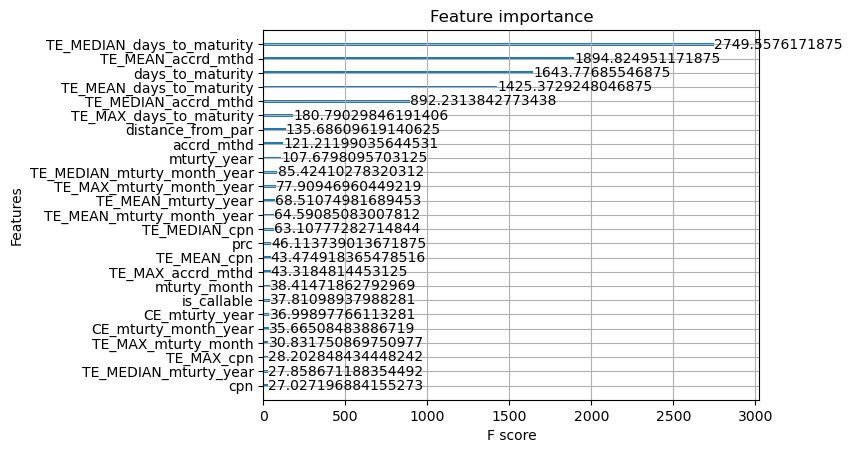

In [54]:
from xgboost import plot_importance

#Plot feature importance
plot_importance(model, importance_type='gain', max_num_features=25)  
# 'weight', 'gain', 'cover' are possible importance types
plt.show()

In [55]:
sub['base_level'] = pred
sub.to_csv('Predictions_LGBM.csv', index=False)
print(sub.shape)
sub.head()

(199, 3)


,risk_sec_code,close_date,base_level
1303167,5545810,2024-04-01,8.484785
1303168,5545810,2024-04-02,8.515923
1303169,5545810,2024-04-03,8.470232
1303170,5545810,2024-04-04,8.478081
1303171,5545810,2024-04-05,8.526451


In [56]:
print(pred)

[8.48478489 8.51592312 8.47023182 8.47808075 8.52645149 8.47639675
 8.42438278 8.41204205 8.5661911  8.42340546 8.51858006 8.60972042
 8.52790928 8.59254303 8.62233143 8.57809715 8.54571495 8.62052536
 8.667906   8.58890438 8.50425148 8.46421223 8.4356184  8.53218575
 8.45806141 8.4295929  8.31443138 8.39108295 8.41759872 8.43942013
 8.44436569 8.46347485 8.27688694 8.39521046 8.42602749 8.48038502
 8.38514137 8.3774971  8.39889641 8.31280689 8.29709435 8.27506237
 8.27818928 8.33614712 8.28269234 8.27462673 8.21862679 8.25602665
 8.28316536 8.32085018 8.31823006 8.23529587 8.25017567 8.20396214
 8.25242748 8.25480671 8.1595789  8.11764965 8.0124794  7.99657249
 8.0154871  8.00751429 8.01489258 8.00034084 7.97818089 7.96990499
 7.95605822 7.91305122 7.93848791 7.8409771  7.71636982 7.83286419
 7.68695345 7.74606867 7.74354916 7.62508821 7.75157375 7.63280602
 7.392799   7.42147913 7.38484068 7.30224524 7.35701628 7.28100481
 7.23975163 7.24851637 7.21184254 7.21964216 7.18053913 7.2159